In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from venn import venn
from matplotlib_venn import venn2,venn3
import ast 

In [2]:
# Get list of FASTA files in the input directory
files = [file for file in Path("input").glob("**/*.fasta") if file.is_file()]
color_map = ["#AFDB00","#72BCE4","#FF00FF","#FF7F0E"]
# Get list of species from the file names
species_list = [file.stem for file in files]

First I extract only the domains that are part of the predicted matrisomes.
This takes some time ~30 min

In [3]:
you_are_sure = False # that you want to run this process which takes a long time

# Define a custom converter function to convert string representations of sets back to sets
def str_to_set(s):
    return set(ast.literal_eval(s))

# List of column names for the InterProScan results
column_names = [
    "Accession", "MD5_digest", "Seq_length", "Analysis", "Signature_accession",
    "Signature_description", "Start", "End", "e-value", "Status", "Date",
    "InterPro_accessions", "InterPro_description", "Go-terms", "pathways"
]

if you_are_sure:
    combined_matrisome = []  # Initialize a list to store combined DataFrames
    species_matr_excl_domains = dict()
    species_non_matr_domains = dict()
    species_matr_domains = dict()
    all_non_matrisome = set()

    pbar = tqdm(species_list)
    for species in pbar:
        pbar.set_description("Processing %s" % species)

        # Read the subset data as a set
        with open(f"output\Sequences\{species}_ecm_subset.txt", "r") as subset_file:
            subset = {line.strip() for line in subset_file}

        ipr_result = pd.read_csv(
            f"output\interproscan_results\{species}\{species}.fasta.tsv",
            sep="\t",
            names=column_names,
            index_col="Accession",
            converters={"InterPro_accessions": str_to_set}
        )

        non_matrisome_iprs = ipr_result[~ipr_result.index.isin(subset)]
        non_matrisome_ipr_accession = set().union(*non_matrisome_iprs["InterPro_accessions"])

        matrisome_iprs = ipr_result[subset]
        matrisome_ipr_accession = set().union(*matrisome_iprs["InterPro_accessions"])

        all_non_matrisome.update(non_matrisome_ipr_accession)
        ECM_exclusive_accessions = matrisome_ipr_accession.difference(non_matrisome_ipr_accession)

        species_matr_domains[species] = matrisome_ipr_accession
        species_matr_excl_domains[species] = ECM_exclusive_accessions
        species_non_matr_domains[species] = non_matrisome_ipr_accession

        matrisome_iprs['Species'] = species
        combined_matrisome.append(matrisome_iprs)  # Append the DataFrame to the list

    # Concatenate all DataFrames at once
    combined_matrisome = pd.concat(combined_matrisome, keys=[df['Species'].iloc[0] for df in combined_matrisome])

    # Save DataFrames to CSV files
    combined_matrisome.to_csv("output\combined_matrisome_iprs.csv")
    pd.Series(species_matr_excl_domains).to_csv("output/tables/matrisome_exclusive_IPRs.csv")
    pd.Series(species_matr_domains).to_csv("output/tables/matrisome_IPRs.csv")
    pd.Series(species_non_matr_domains).to_csv("output/tables/non_matrisome_IPRs.csv")
else:
    combined_matrisome = pd.read_csv("output\combined_matrisome_iprs.csv", index_col=[0, 1])
    species_matr_excl_domains = pd.read_csv("output/tables/matrisome_exclusive_IPRs.csv", index_col=0, converters={"0": str_to_set})
    species_matr_domains = pd.read_csv("output/tables/matrisome_IPRs.csv", index_col=0, converters={"0": str_to_set})
    species_non_matr_domains = pd.read_csv("output/tables/non_matrisome_IPRs.csv", index_col=0, converters={"0": str_to_set})



C:\Users\gideon.b\AppData\Local\Temp\ipykernel_5324\2508464370.py:62: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_matrisome = pd.read_csv("output\combined_matrisome_iprs.csv", index_col=[0, 1])


The species are not organized well so we have to reorder the columns a bit

In [4]:
#species of interest
sorted_species_list = [
       #Choanoflagellata
       'Salpingoeca_rosetta','Monosiga_brevicollis',
       #Porifera
       'Amphimedon_queenslandica',
       #Ctenophora
       'Beroe_ovata','Pleurobrachia_bachei','Mnemiopsis_leidyi',
       #Placozoa
       'Trichoplax_specH2','Tricoplax_adhaerens',
       #Myxozoa
       'Thelohanellus_kitauei','Myxobolus_honghuensis',
       #Cubozoa
       'Morbakka_virulenta',
       #Staurozoa
       'Calvadosia_cruxmelitensis',
       #Scyphozoa
       'Cassiopea_xamachana','Aurelia_aurita', 
       #Hydrozoa
       'Hydra_viridissima','Hydra_vulgaris','Hydractinia_echinata','Hydractinia_symbiolongicarpus','Clytia_hemispherica',
       #Anthozoa
       'Nematostella_vectensis','Actinia_tenebrosa','Stylophora_pistillata','Exaiptasia_diaphana', 
       'Acropora_millepora','Acropora_digitifera','Xenia_spec','Acropora_cervicornis', 'Pocillopora_damicornis',
       'Montipora_aequituberculata','Porites_asteroides','Pocillopora_verrucosa','Acropora_muricata','Acropora_hyacinthus',
       'Montipora_foliosa','Renilla_reniformis',
       #Nematoda
       'Caenorhabditis_elegans',
       #Plathelminthes
       'Schmidtea_mediterranea',
       #Chordata
       'Homo_sapiens','Mus_musculus']
combined_matrisome = combined_matrisome.loc[sorted_species_list]
#renaming the species
renamed_species_list = [
       #Choanoflagellata
       'S. rosetta','M. brevicollis',
       #Porifera
       'A. queenslandica',
       #Ctenophora
       'B. ovata','P. bachei','M. leidyi',
       #Placozoa
       'T. spec-H2','T. adhaerens',
       #Myxozoa
       'T. kitauei','M. honghuensis',
       #Cubozoa
       'M. virulenta',
       #Staurozoa
       'C. cruxmelitensis',
       #Scyphozoa
       'C. xamachana','A. aurita', 
       #Hydrozoa
       'H. viridissima','H. vulgaris','H. echinata','H. symbiolongicarpus','C. hemispherica',
       #Anthozoa
       'N. vectensis','A. tenebrosa','S. pistillata','E. diaphana', 
       'A. millepora','A. digitifera','X. spec','A. cervicornis', 'P. damicornis',
       'M. aequituberculata','P. asteroides','P. verrucosa','A. muricata','A. hyacinthus',
       'M. foliosa','R. reniformis',
       #Nematoda
       'C. elegans',
       #Plathelminthes
       'S. mediterranea',
       #Chordata
       'H. sapiens','M. musculus']
rename_species_dict = {old_name:new_name for old_name,new_name in zip(sorted_species_list,renamed_species_list)}

This allows us to identify all domains that are ECM exclusive. 
First we can check the amount of domains that are ECM exclusive when looking at each organism individually 

In [5]:
len(species_matr_domains.values[0][0])

350

C:\Users\gideon.b\AppData\Local\Temp\ipykernel_5324\961368559.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  species_ECM_domains_count = species_matr_domains.applymap(len)


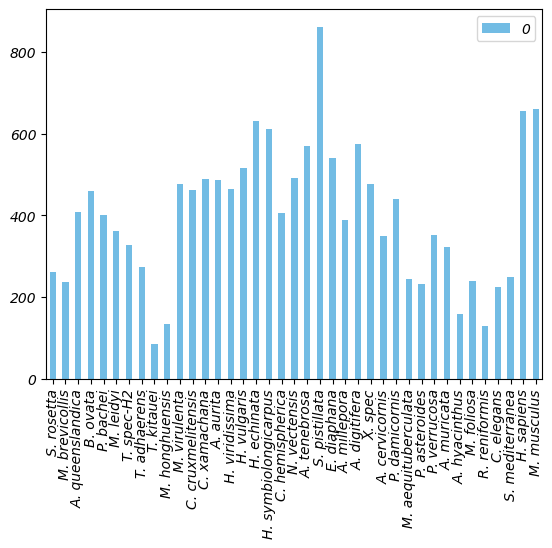

In [6]:
species_ECM_domains_count = species_matr_domains.applymap(len)
species_ECM_domains_count = species_ECM_domains_count.loc[sorted_species_list] 
species_ECM_domains_count.index = renamed_species_list

species_ECM_domains_count.to_csv("output\graphs\domain_analysis\ECM_domain_counts_per_species.csv")
species_ECM_domains_count.plot(kind="bar",color= color_map[1])
plt.savefig("output\graphs\domain_analysis\ECM_domain_counts_per_species.svg") 

In [7]:
species_ECM_domains_count.loc[species_ECM_domains_count["0"] <= 236]

0
M. brevicollis  236
T. kitauei       84
M. honghuensis  134
P. asteroides   231
A. hyacinthus   158
R. reniformis   128
C. elegans      224

And we can combine these together

In [8]:
ECM_exclusive_domains_species = set()

# Iterate through the sets in species_matr_domains and compute their union
for species, matr_domain_set in species_matr_domains.items():
    for domain_set in matr_domain_set:
        ECM_exclusive_domains_species |= set(domain_set)

# Now, 'ECM_exclusive_domains_species' contains the union of all sets in 'species_matr_domains'
len(ECM_exclusive_domains_species)

2469

In [13]:
curated_matrisome = pd.read_excel("Candidate Liste.xlsx",index_col=0)

## Number of domains in each Domain databank per species
InterProscan uses different databases to identify different domain types. I would be interested to know the number of domains found in each of the databases

In [14]:
def calculate_length(item):
    if isinstance(item, (list, np.ndarray)):
        return len(item)
    else:
        return 0

database_families = {"CDD":"Families, domains,sites & repeats",
                     "Coils": "Coil regions",
                     "Gene3D":"Structural domains",
                     "Hamap" : "Families, domains,sites & repeats",
                     "MobiDBLite" : "Structural domains",
                     "PANTHER" : "Families, domains,sites & repeats",
                     "PIRSF": "Families, domains,sites & repeats",
                     "PRINTS": "Families, domains,sites & repeats",
                     "Pfam":"Families, domains,sites & repeats",
                     "Phobius":"Transmembrane and signal peptide",
                     "ProSitePatterns":"Families, domains,sites & repeats",
                     "ProSiteProfiles":"Families, domains,sites & repeats",
                     "SFLD":"Families, domains,sites & repeats",
                     "SMART":"Families, domains,sites & repeats",
                     "SUPERFAMILY":"Structural domains",
                     "TIGRFAM":"Other Categories"}

species_analysis = combined_matrisome.groupby(["Species","Analysis"])
unstacked =species_analysis.Signature_description.unique().unstack(level=0)
unstacked = unstacked[sorted_species_list]
unstacked.columns = renamed_species_list
database_counts = unstacked.applymap(calculate_length)
database_counts.index= [(database_families.get(index,),index) for index in database_counts.index]
database_counts.index = pd.MultiIndex.from_tuples(list(database_counts.index),names=["category","database"])
database_counts = database_counts.sort_index()

C:\Users\gideon.b\AppData\Local\Temp\ipykernel_5324\2565158047.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  database_counts = unstacked.applymap(calculate_length)


In [15]:
def bubble_heatmap(df,factor): 
    plt.figure(figsize=(15, len(df.index)*0.25))
    # Iterate through each species and create bubbles
    for index, species in enumerate(df.columns):
        counts = df.iloc[:, index].fillna(0)
        
        plt.scatter([index] * len(counts), np.arange(len(counts)),
                    s=[count*factor for count in counts],  # Adjust the bubble size as needed
                    c=counts, cmap='Blues',
                    edgecolors='black', linewidths=1, alpha=0.7)
            # Set y-axis ticks and labels to be the InterPro descriptions
    plt.yticks(np.arange(len(counts)), counts.index)

    # Set x-axis ticks and labels to be the species names, and rotate the labels by 90°
    plt.xticks(np.arange(len(df.columns)), df.columns, rotation=90)

    # Add a colorbar for reference
    cbar = plt.colorbar()
    cbar.set_label('Count')

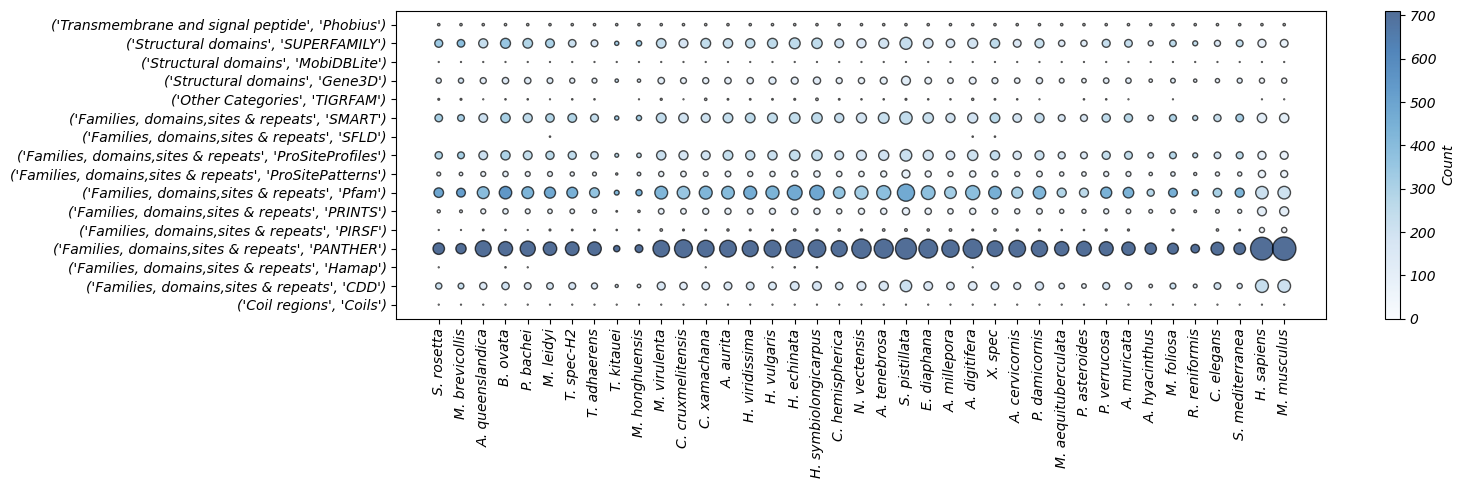

In [16]:
bubble_heatmap(database_counts,0.4)
plt.savefig("output/graphs/domain_analysis/DB_comparison.svg")

## Domain abundance in the different databases
Now we have to take a look at the domain of the different domains in the actual matrisomes

In [18]:
def DB_domain_count(database,num_domains = 25,sort_by="N. vectensis",bubble_map_factor=0.3):
    smart_set = combined_matrisome.loc[(combined_matrisome.Analysis == database) & (combined_matrisome.InterPro_description != "-")]
    if len(smart_set.index) != 0:
        smart_groups = smart_set.groupby("Species")
        smart_domain_count = smart_groups.InterPro_description.value_counts()


        domain_counts_of_interest = smart_domain_count.unstack(level=0).dropna(how="all")
        valid_columns = [col for col in sorted_species_list if col in domain_counts_of_interest.columns]
        new_col_names = [new_col for new_col,col in zip(renamed_species_list,sorted_species_list) if col in domain_counts_of_interest.columns]
        domain_counts_of_interest = domain_counts_of_interest[valid_columns]
        domain_counts_of_interest.columns = new_col_names

        if sort_by in domain_counts_of_interest.columns: 
            #sort by the domain counts of Nematostella
            domain_counts_of_interest=domain_counts_of_interest.sort_values(sort_by,ascending=False)

        if not num_domains:
                    num_domains = len(domain_counts_of_interest.index)
        else:
            domain_counts_of_interest =  domain_counts_of_interest.head(num_domains)
        #create the plot    
        bubble_heatmap(domain_counts_of_interest,factor = bubble_map_factor)
        plt.title = database + " domains"
        # Adjust layout for better visualization
        plt.tight_layout()
        plt.savefig(f"output/graphs/domain_analysis/domain_counts/{database}_domain_counts(top_{num_domains}).svg")
        # Display the plot
        plt.show()

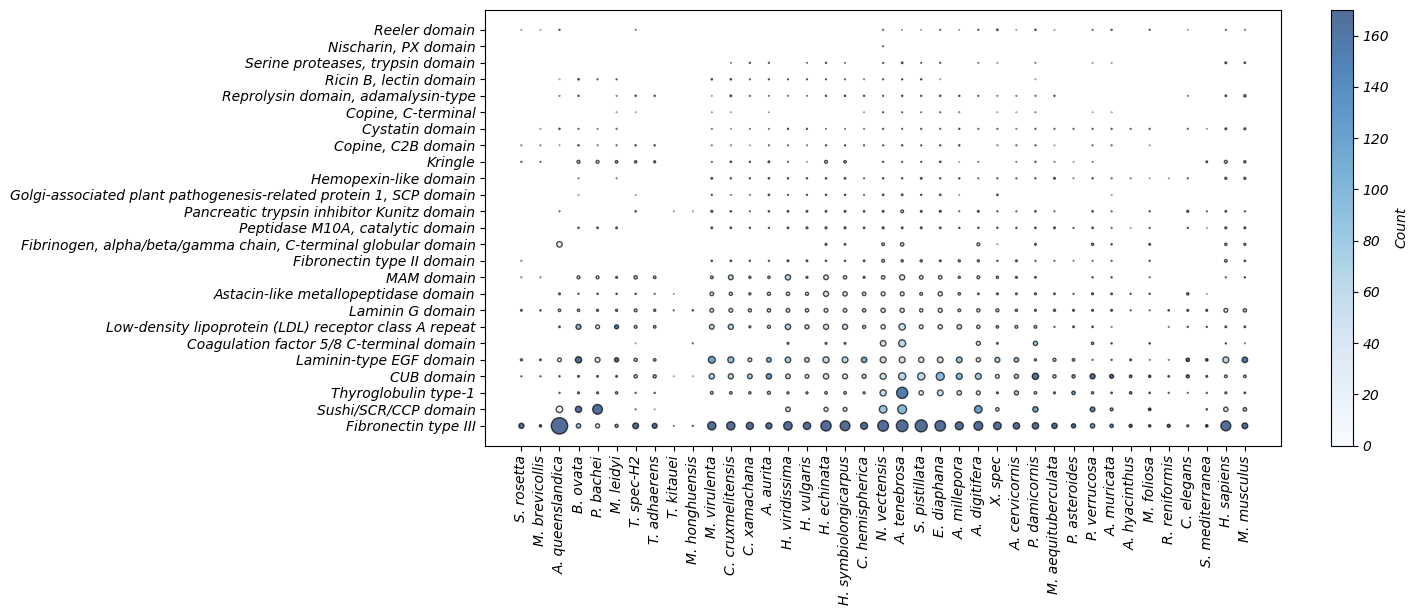

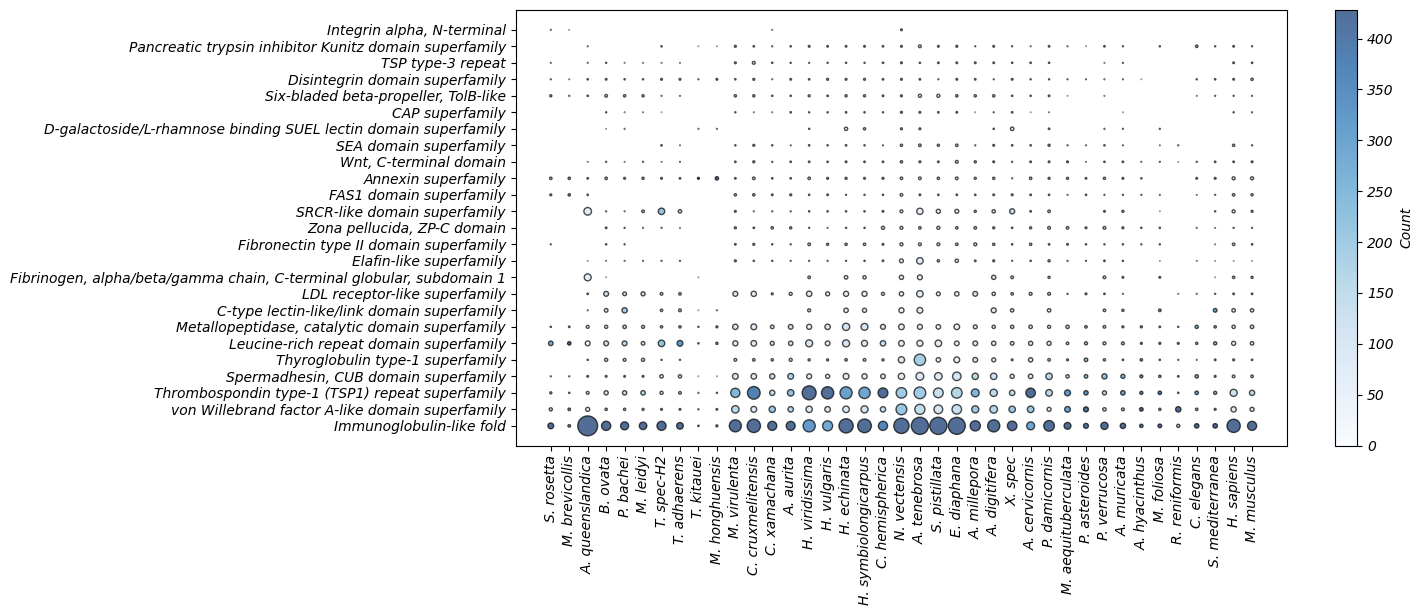

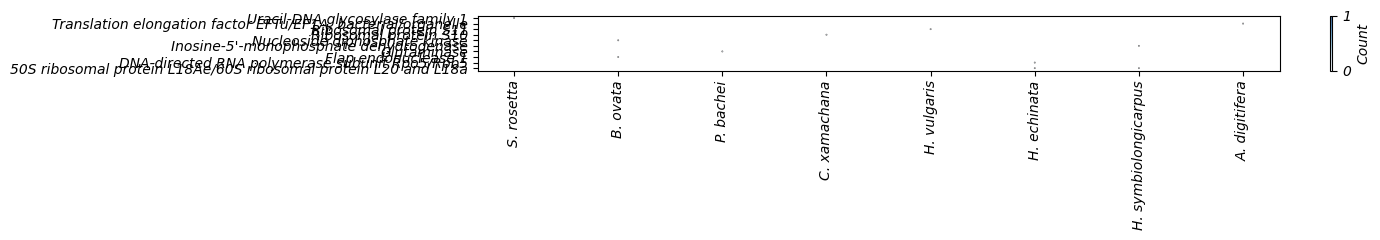

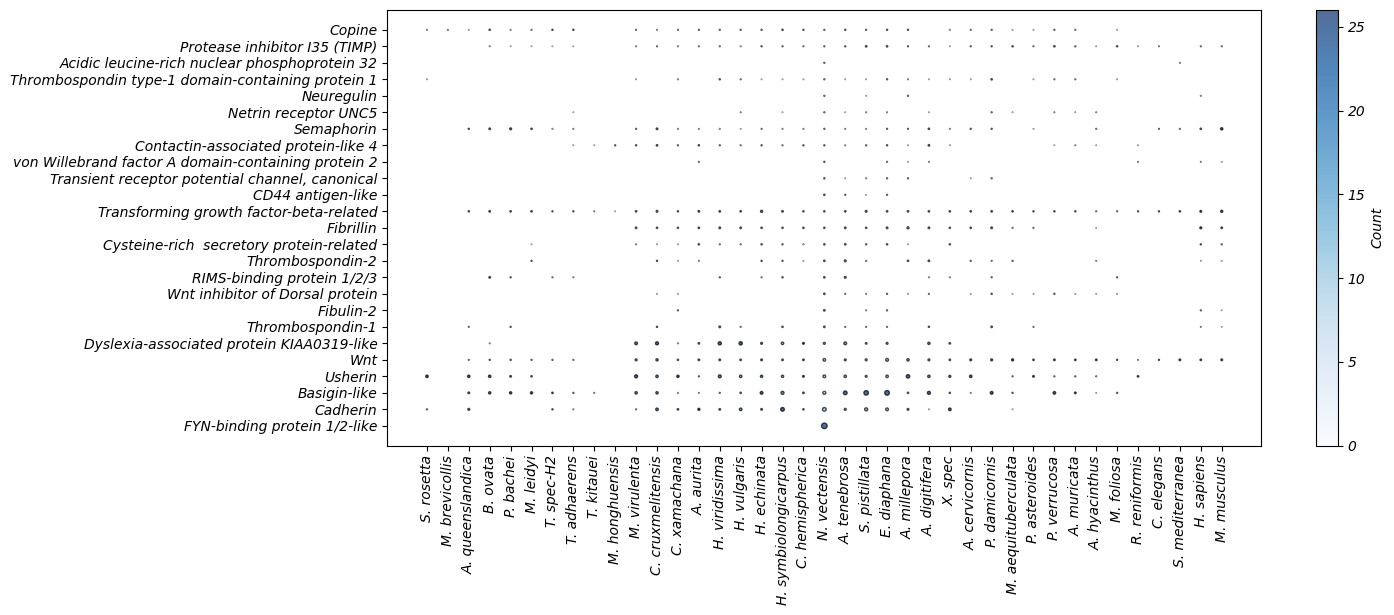

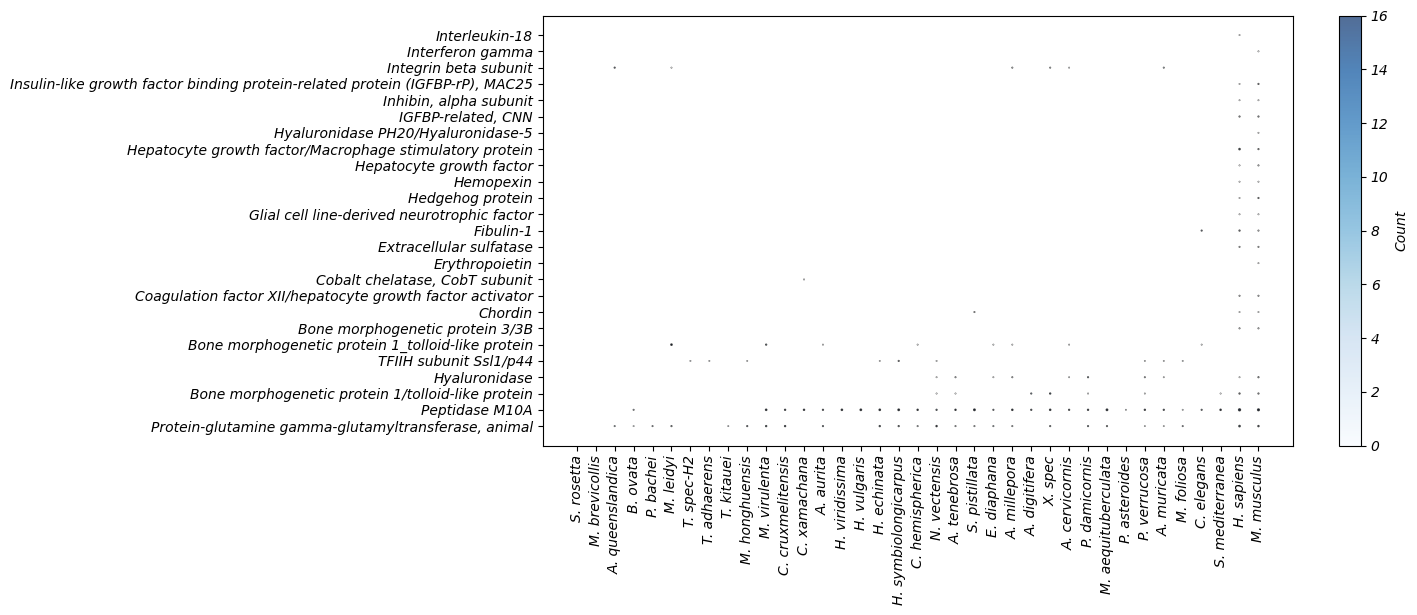

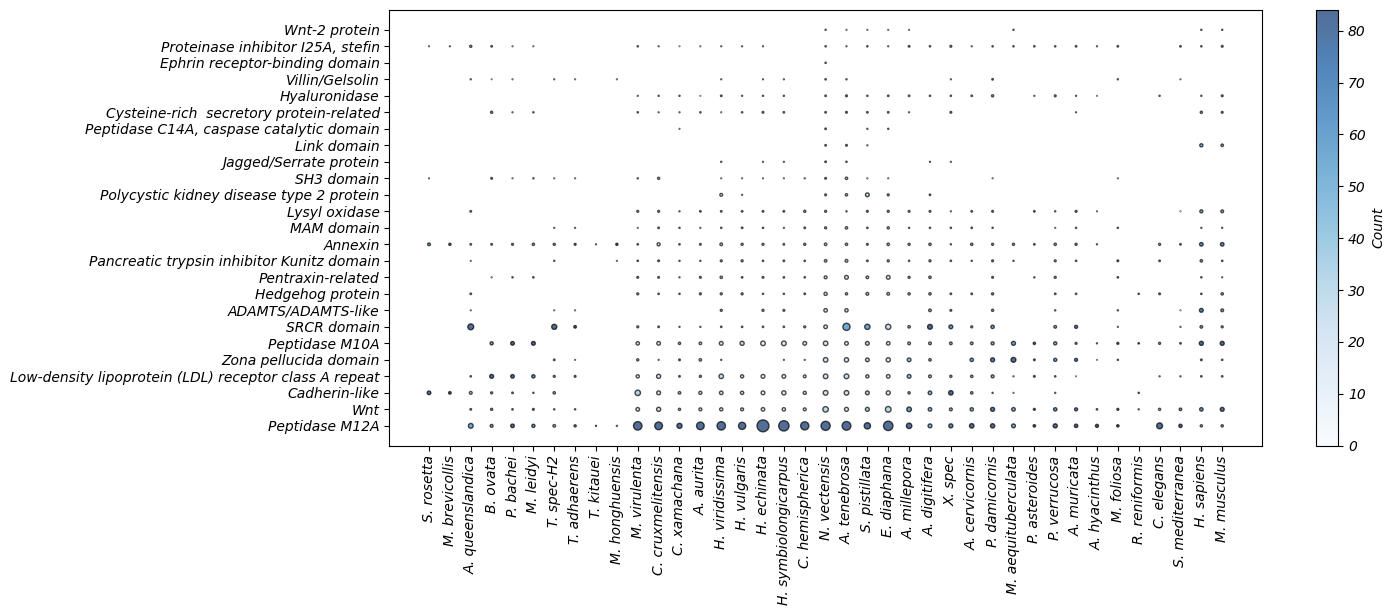

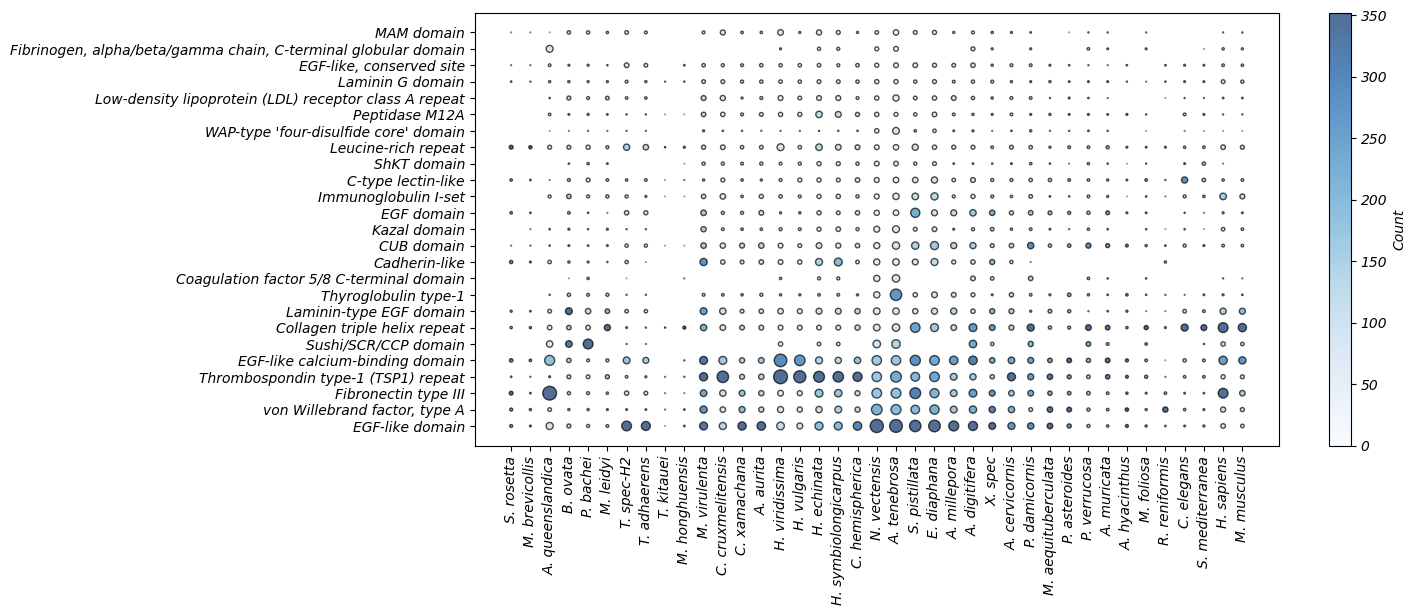

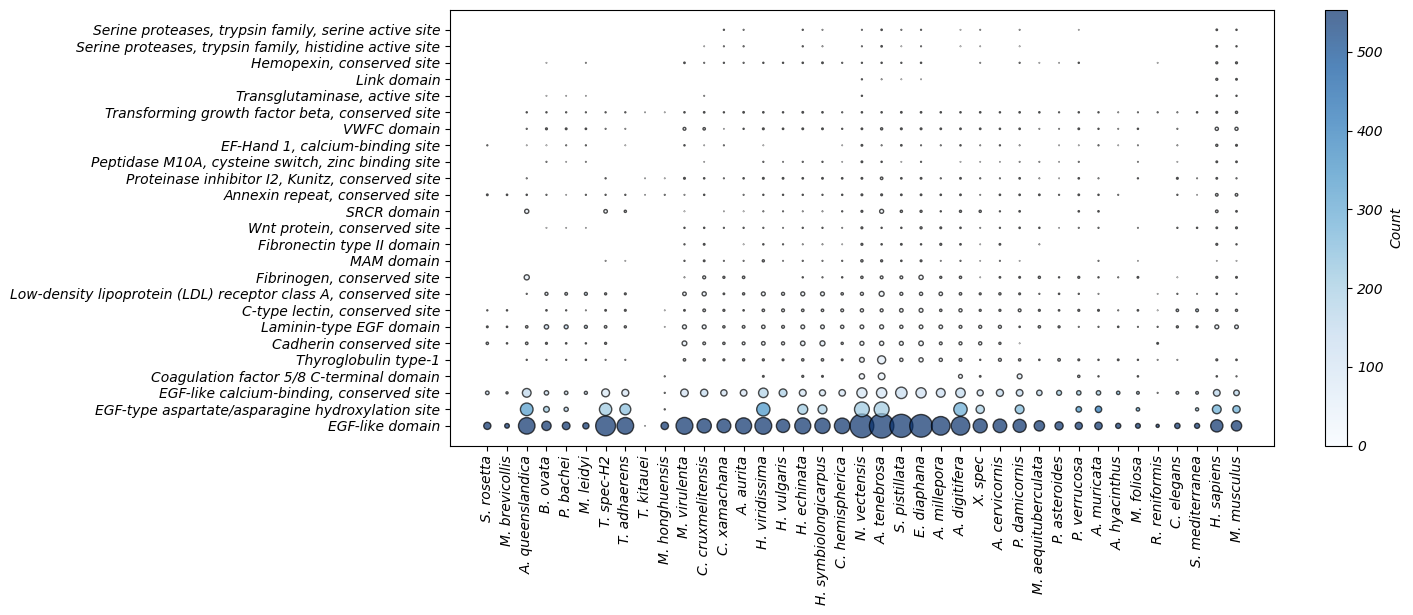

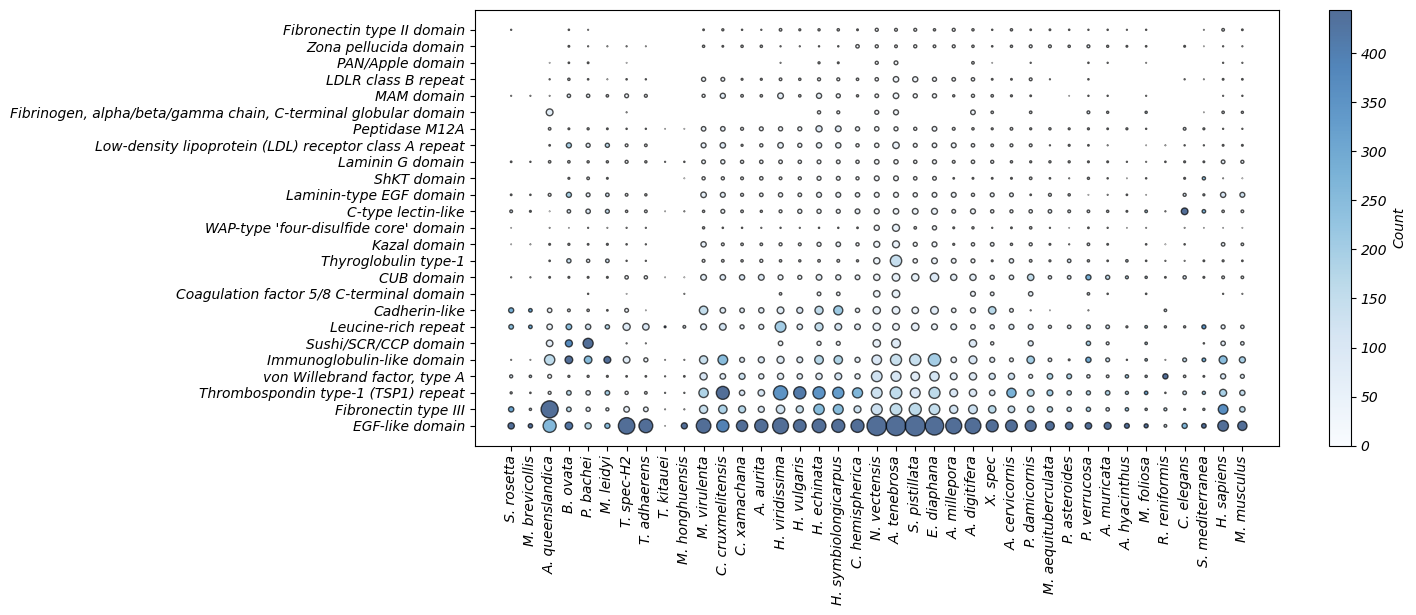

C:\Users\gideon.b\AppData\Local\Temp\ipykernel_5324\1583333363.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


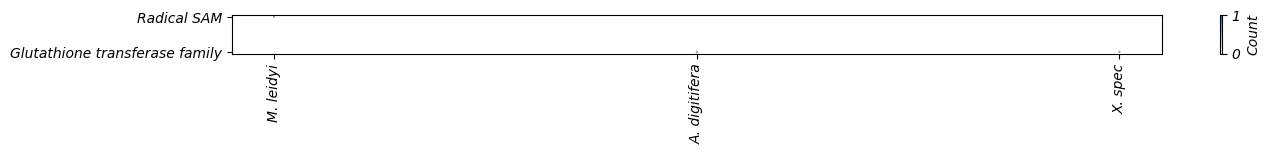

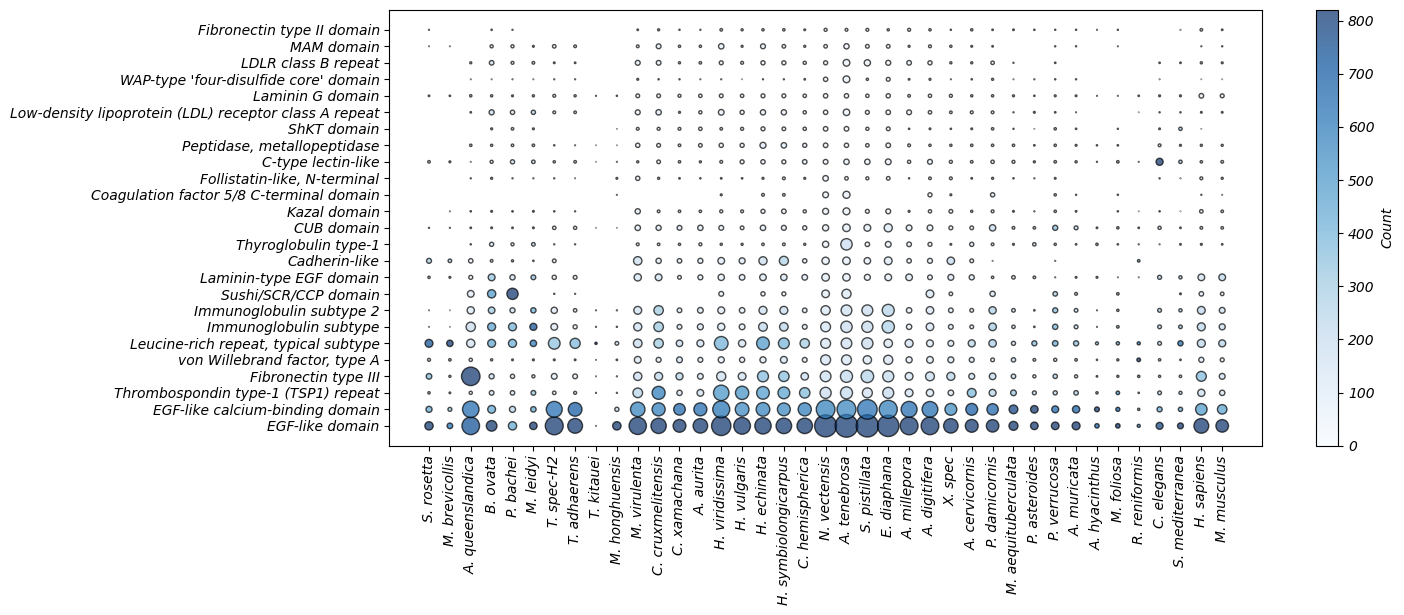

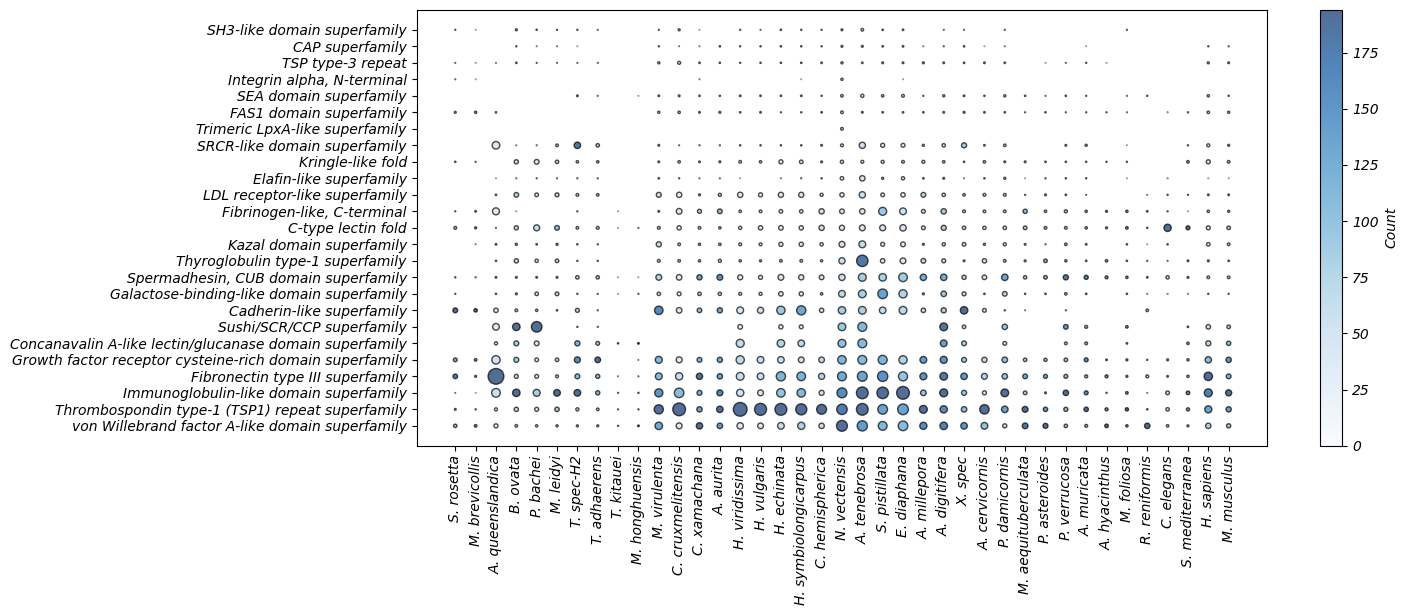

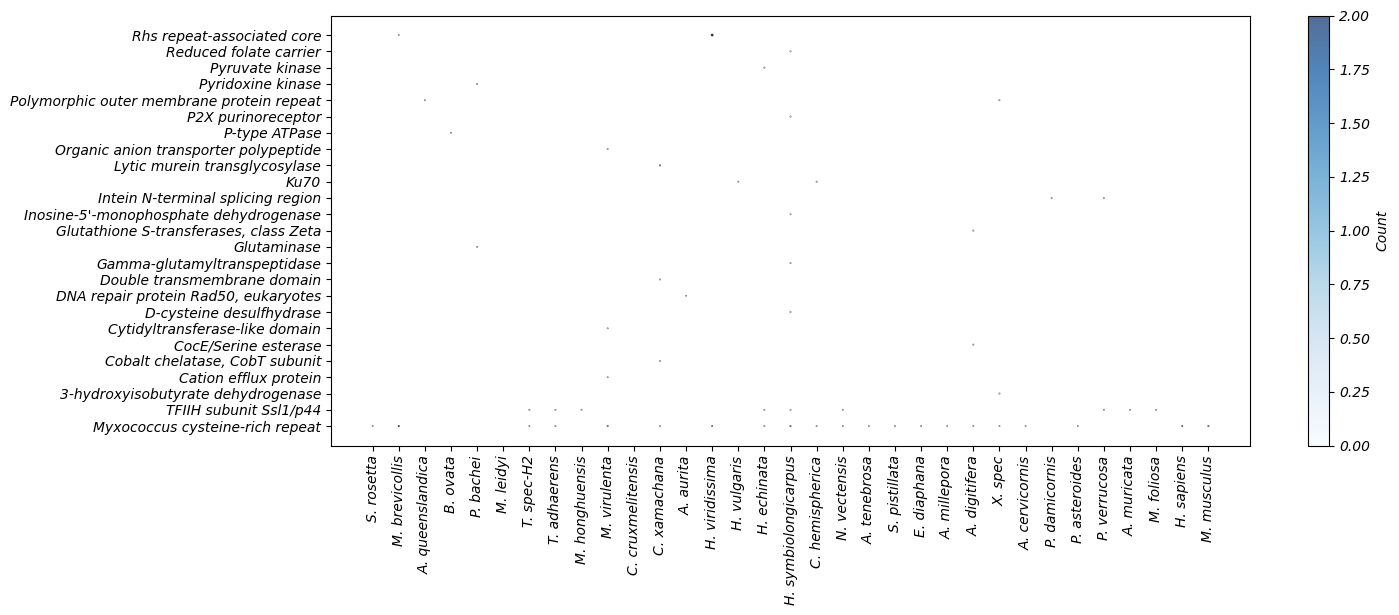

In [19]:
for database in database_families.keys():
    DB_domain_count(database, num_domains=25,bubble_map_factor = 0.1)

In [20]:
def bubble_heatmap_relative_counts(database,num_domains = 25,sort_by="N. vectensis",bubble_map_factor=1):
    smart_set = combined_matrisome.loc[(combined_matrisome.Analysis == database) & (combined_matrisome.InterPro_description != "-")]
      

    if len(smart_set.index) != 0:
        smart_groups = smart_set.groupby("Species")
        smart_domain_count = smart_groups.InterPro_description.value_counts()
        smart_domain_count = smart_domain_count.div(smart_domain_count.sum())*100 

        domain_counts_of_interest = smart_domain_count.unstack(level=0).dropna(how="all")
        valid_columns = [col for col in sorted_species_list if col in domain_counts_of_interest.columns]
        new_col_names = [new_col for new_col,col in zip(renamed_species_list,sorted_species_list) if col in domain_counts_of_interest.columns]
        domain_counts_of_interest = domain_counts_of_interest[valid_columns]
        domain_counts_of_interest.columns = new_col_names

        if sort_by in domain_counts_of_interest.columns: 
            #sort by the domain counts of Nematostella
            domain_counts_of_interest=domain_counts_of_interest.sort_values(sort_by,ascending=False)

        if not num_domains:
                    num_domains = len(domain_counts_of_interest.index)
        else:
            domain_counts_of_interest =  domain_counts_of_interest.head(num_domains)
        #create the plot    
        bubble_heatmap(domain_counts_of_interest, factor =bubble_map_factor)
        plt.title = database + " domains"
        # Adjust layout for better visualization
        plt.tight_layout()
        plt.savefig(f"output/graphs/domain_analysis/domain_counts/{database}_relative_domain_counts(top_{num_domains}).svg")
        # Display the plot
        plt.show()



CDD


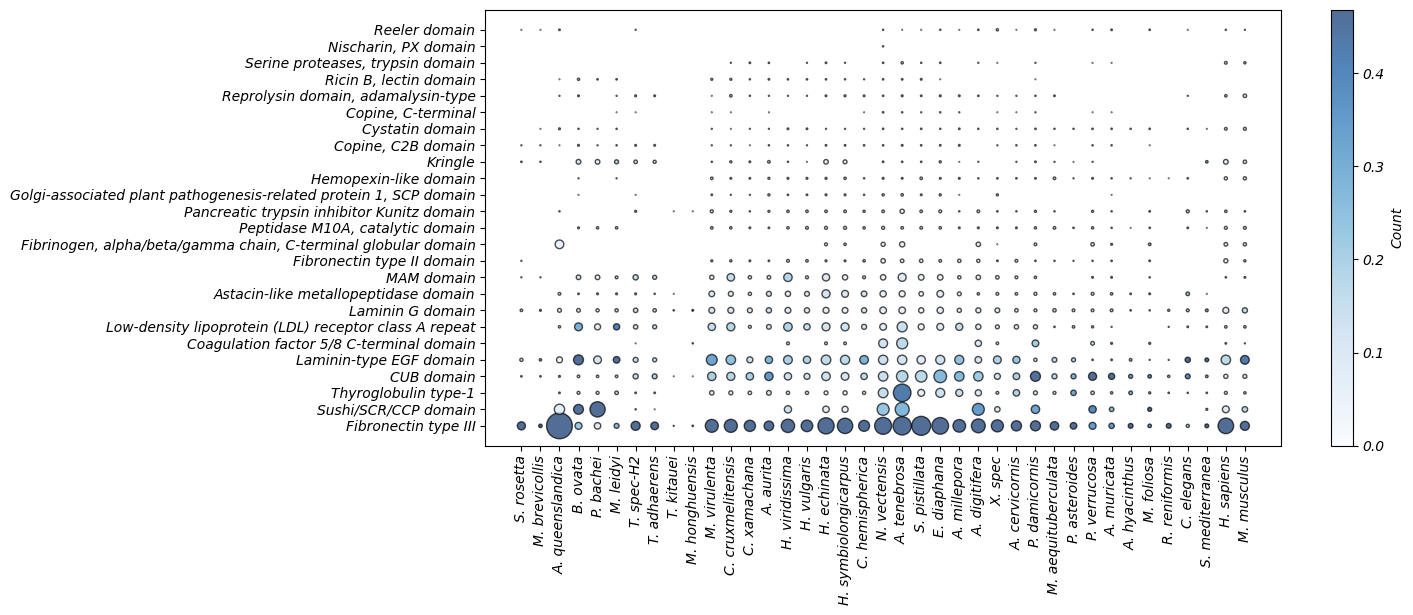

Coils
Gene3D


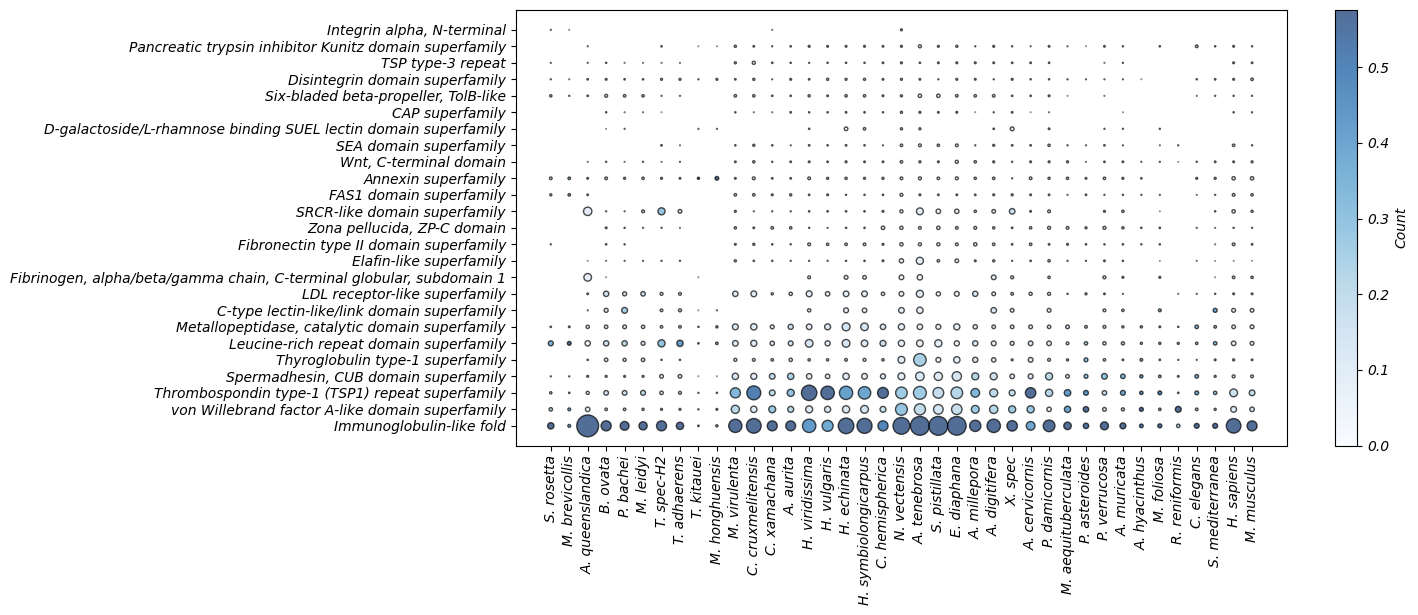

Hamap


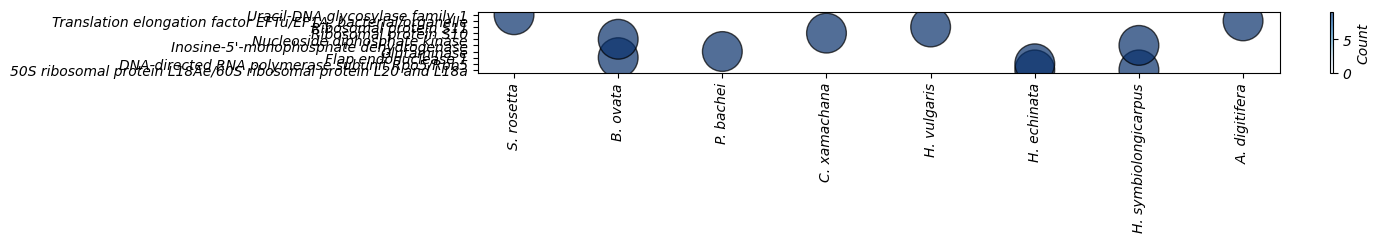

MobiDBLite
PANTHER


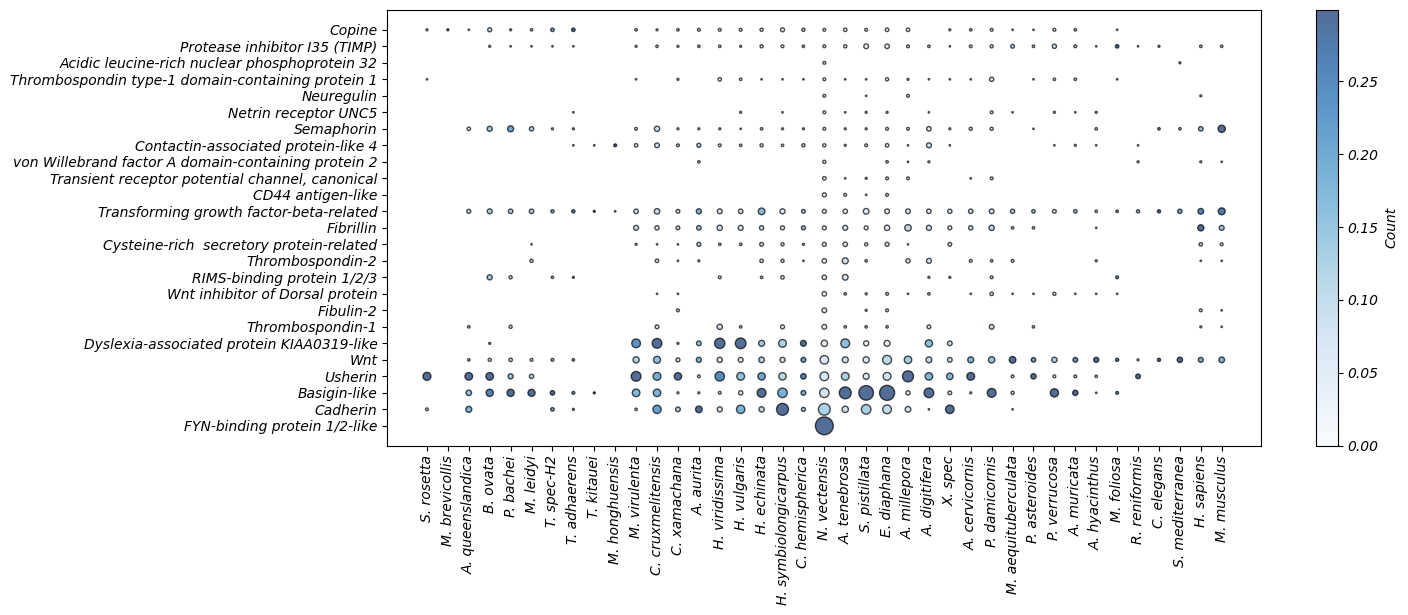

PIRSF


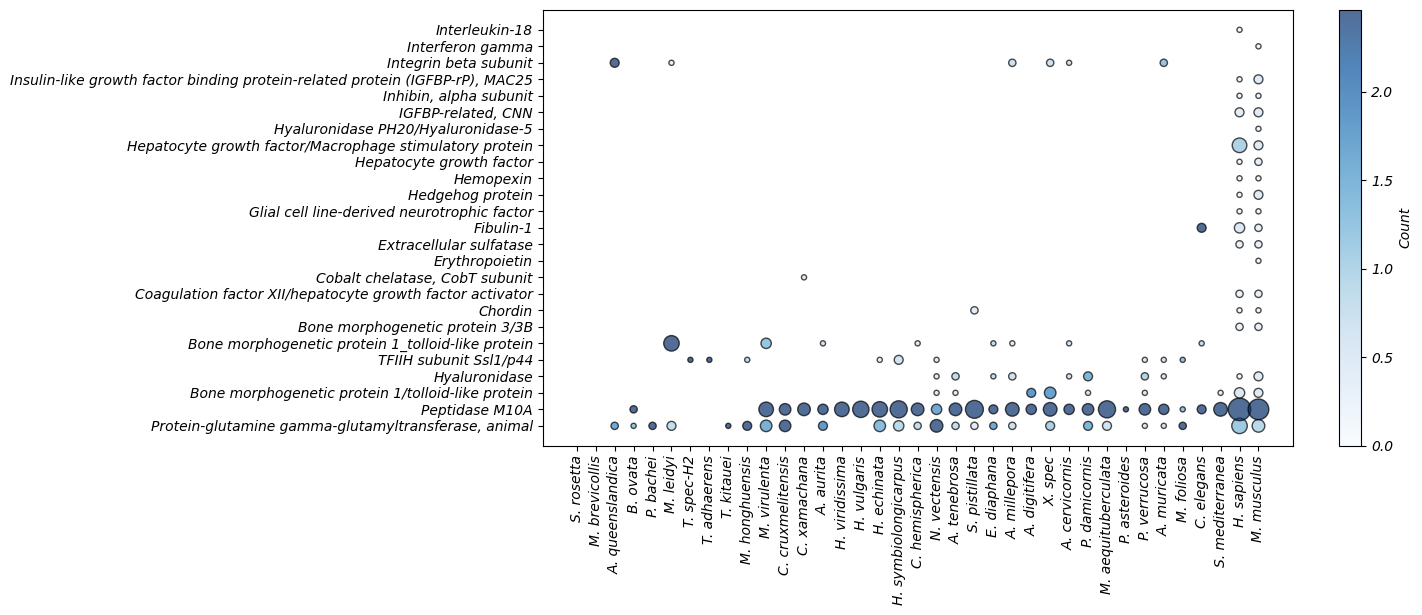

PRINTS


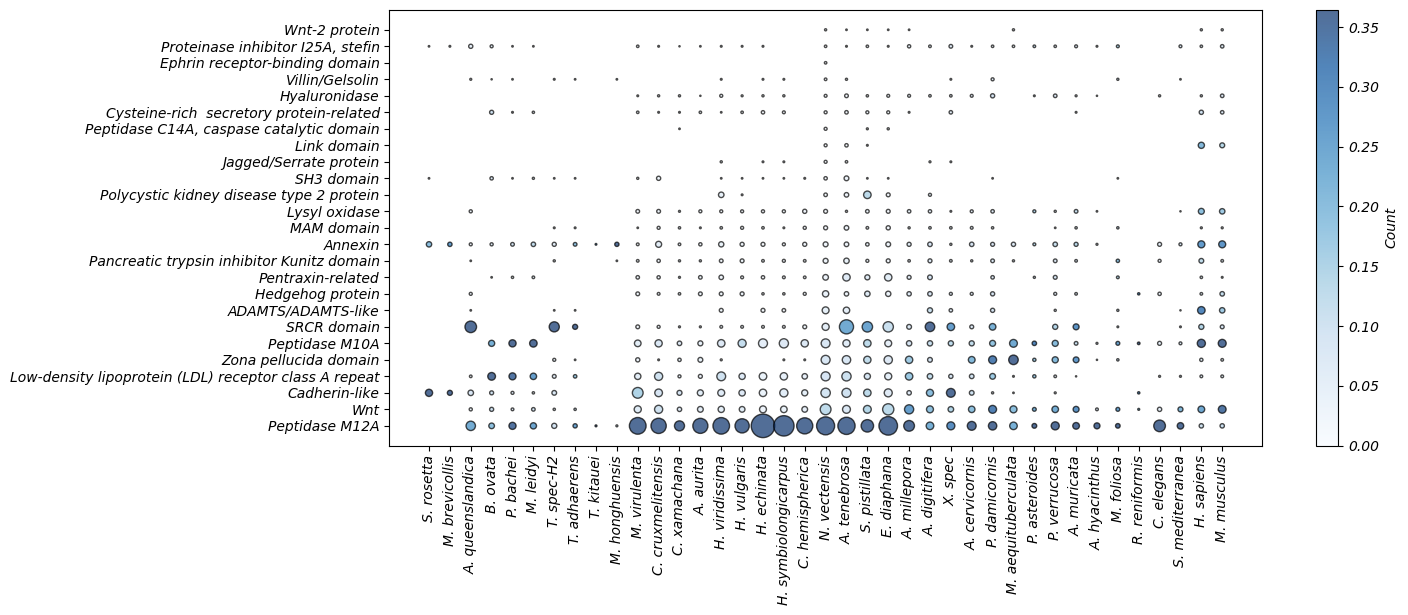

Pfam


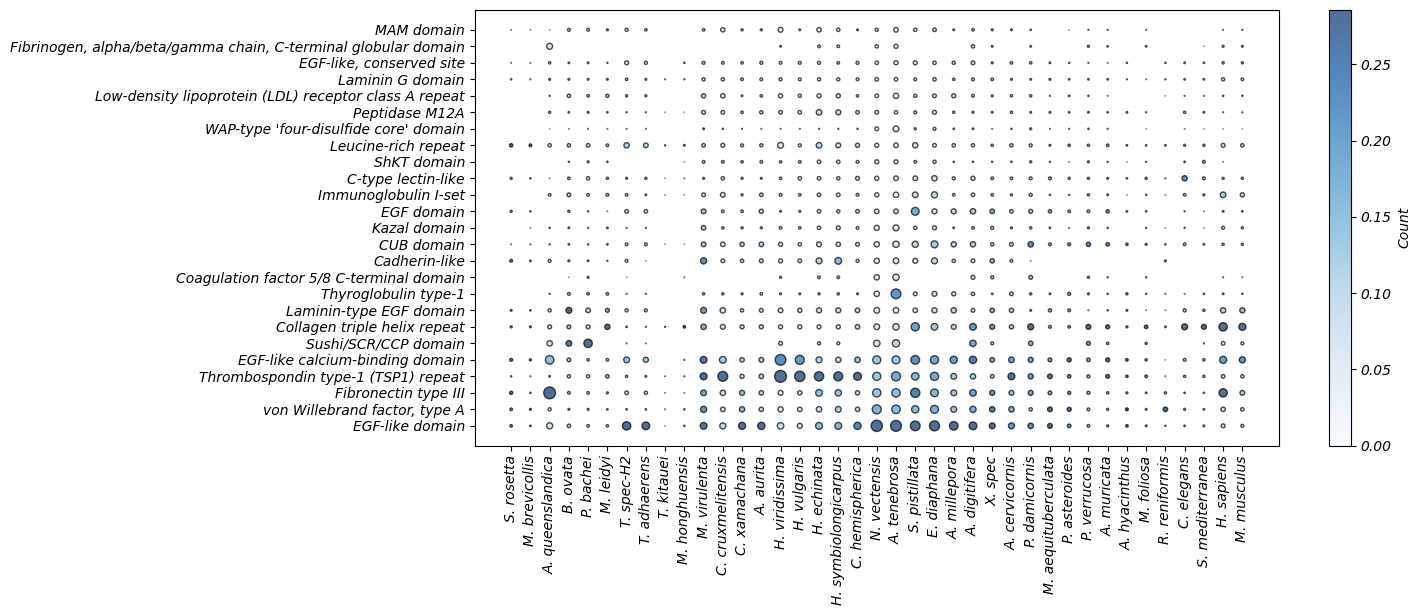

Phobius
ProSitePatterns


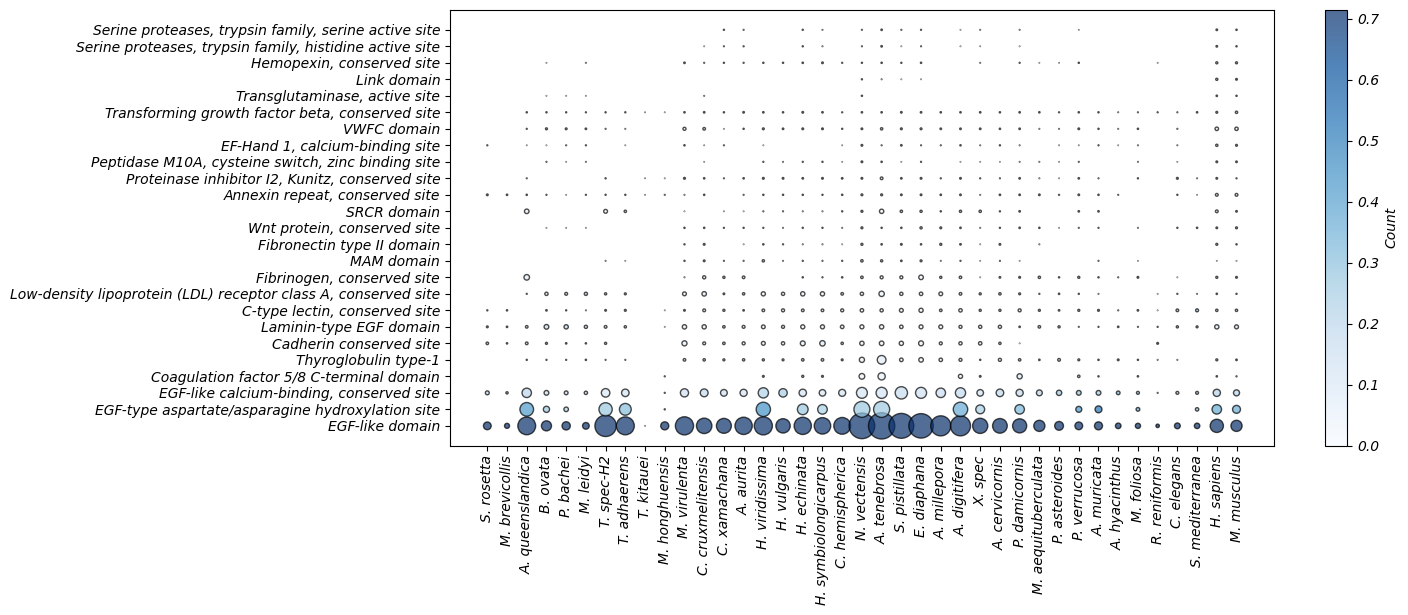

ProSiteProfiles


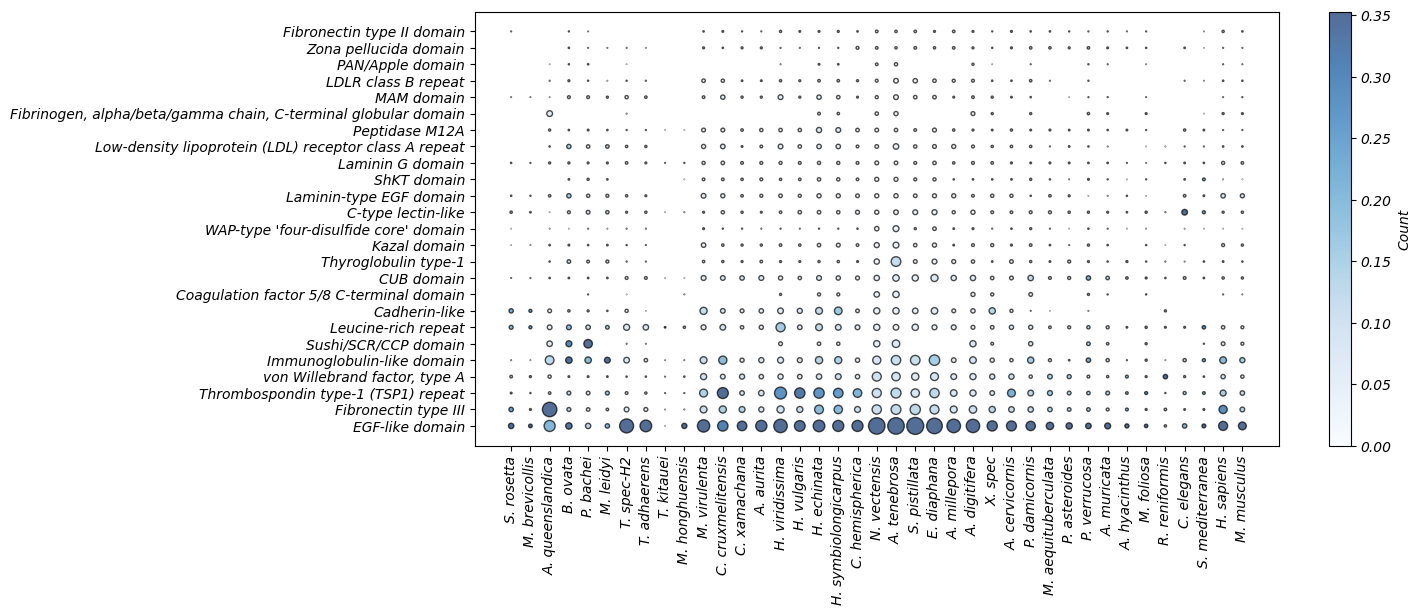

SFLD


C:\Users\gideon.b\AppData\Local\Temp\ipykernel_5324\770940085.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


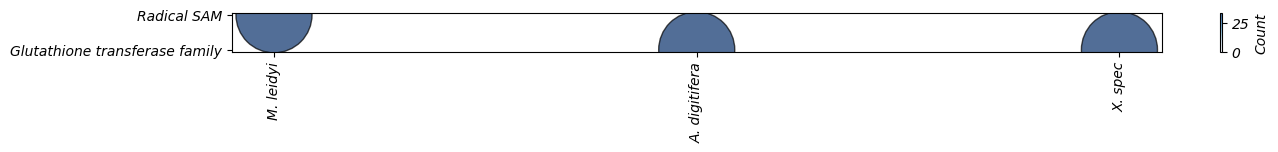

SMART


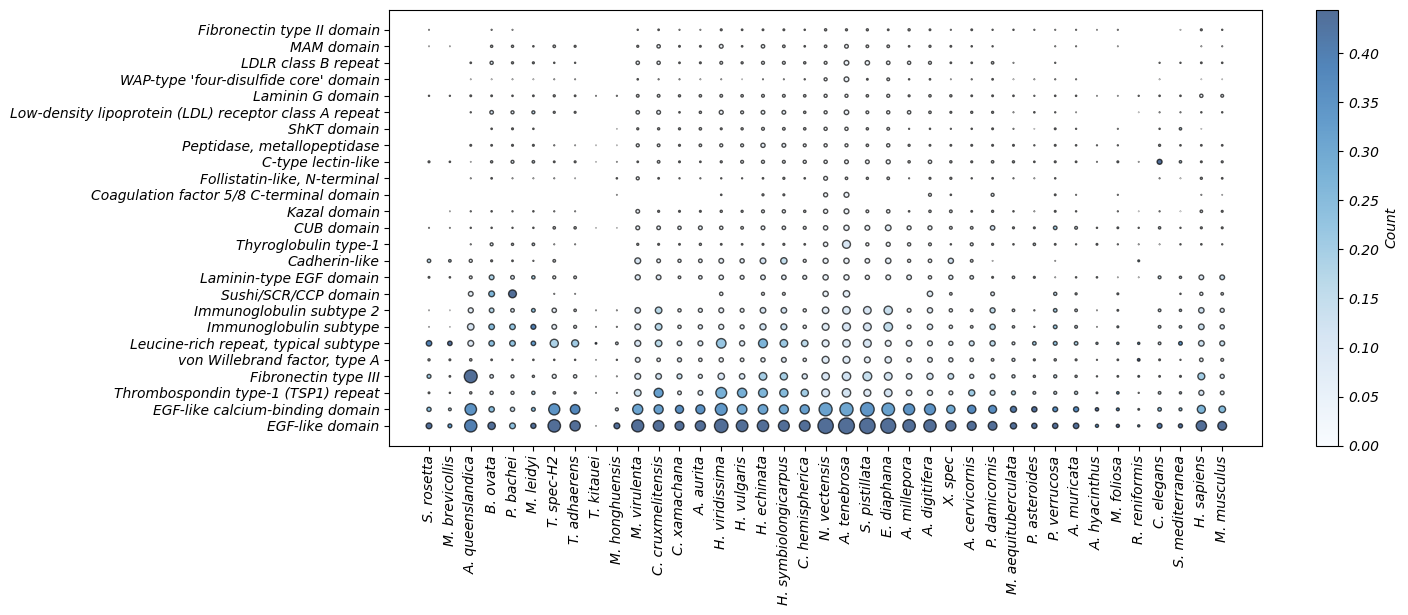

SUPERFAMILY


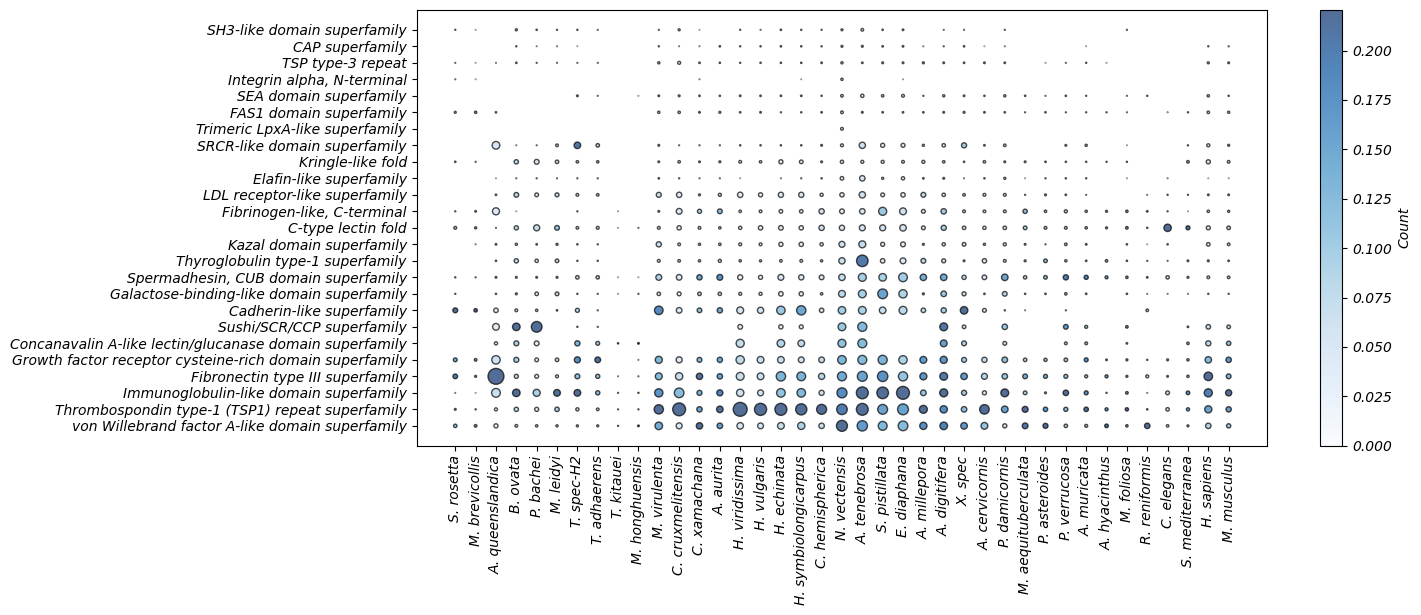

TIGRFAM


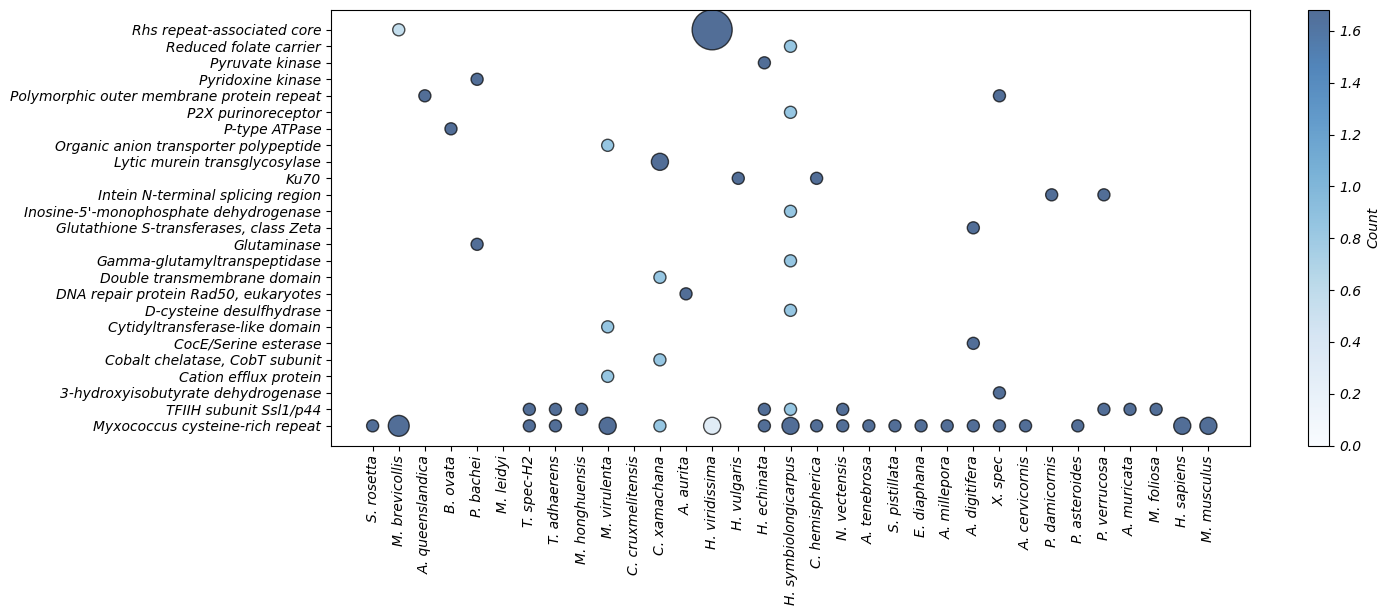

In [21]:
for database in database_families.keys():
    print(database)
    bubble_heatmap_relative_counts(database, num_domains=25,bubble_map_factor=90)

I   want to be able to extract proteins based on domains from the ECM Proteome

In [22]:
#extract by domains
import pandas as pd

iprs_of_interest = ["IPR034113","IPR034117","IPR034121"]


In [23]:
read_full_dataset = pd.read_csv(r"output\interproscan_results\Nematostella_vectensis\Nematostella_vectensis_matrisome.csv")



In [24]:
genes_of_interest = read_full_dataset.loc[read_full_dataset.InterPro_accessions.isin(iprs_of_interest)]

genes_of_interest.to_excel("SCP_genes.xlsx")

In [25]:
genes_of_interest

Accession  \
8528   Nematostella_vectensis_NV2t003157001.1   
8544   Nematostella_vectensis_NV2t003157001.1   
23816  Nematostella_vectensis_NV2t010388001.1   
23841  Nematostella_vectensis_NV2t010388002.1   
23876  Nematostella_vectensis_NV2t010391001.1   
42015  Nematostella_vectensis_NV2t015872001.1   
45911  Nematostella_vectensis_NV2t017517001.1   
46237  Nematostella_vectensis_NV2t017827001.1   
46273  Nematostella_vectensis_NV2t017827002.1   
46303  Nematostella_vectensis_NV2t017827003.1   

                             MD5_digest  Seq_length Analysis  \
8528   36baa6de4a3a6e486367424942fad9ee        1017      CDD   
8544   36baa6de4a3a6e486367424942fad9ee        1017      CDD   
23816  52907d913ef463f1fee6e4a63eff3cb8         891      CDD   
23841  a44fa163520aa062d44c43b25650ac53         912      CDD   
23876  5f2a0746761ec2d8b470806effa04ef1         885      CDD   
42015  5119cfb766337284514d3e468d63edb3        1090      CDD   
45911  9480230ede6919c9b4ae644d424e9e4e         729      CDD   
46237  0958be9d27126ed22d51a868fe84588e         868      CDD   
46273  1c730b7f56082b78e87b7502a5b5e7cc         850      CDD   
46303  1c730b7f56082b78e87b7502a5b5e7cc         850      CDD   

      Signature_accession Signature_description  Start  End      e-value  \
8528              cd05382        CAP_GAPR1-like    339  478  3.22812E-35   
8544              cd05382        CAP_GAPR1-like    848  978   6.2568E-64   
23816             cd05382        CAP_GAPR1-like    319  448  1.05626E-38   
23841             cd05382        CAP_GAPR1-like    340  469  9.77432E-39   
23876             cd05382        CAP_GAPR1-like    504  633  1.23497E-38   
42015             cd05382        CAP_GAPR1-like     52  180  1.97232E-36   
45911             cd05382        CAP_GAPR1-like    562  691  4.28603E-38   
46237             cd05382        CAP_GAPR1-like    718  852  6.86836E-52   
46273             cd05382        CAP_GAPR1-like    700  834  5.02923E-52   
46303             cd05382        CAP_GAPR1-like    700  834  5.02923E-52   

      Status        Date InterPro_accessions  \
8528       T  20-03-2023           IPR034113   
8544       T  20-03-2023           IPR034113   
23816      T  20-03-2023           IPR034113   
23841      T  20-03-2023           IPR034113   
23876      T  20-03-2023           IPR034113   
42015      T  20-03-2023           IPR034113   
45911      T  20-03-2023           IPR034113   
46237      T  20-03-2023           IPR034113   
46273      T  20-03-2023           IPR034113   
46303      T  20-03-2023           IPR034113   

                                    InterPro_description  Go-terms  pathways  
8528   Golgi-associated plant pathogenesis-related pr...       NaN       NaN  
8544   Golgi-associated plant pathogenesis-related pr...       NaN       NaN  
23816  Golgi-associated plant pathogenesis-related pr...       NaN       NaN  
23841  Golgi-associated plant pathogenesis-related pr...       NaN       NaN  
23876  Golgi-associated plant pathogenesis-related pr...       NaN       NaN  
42015  Golgi-associated plant pathogenesis-related pr...       NaN       NaN  
45911  Golgi-associated plant pathogenesis-related pr...       NaN       NaN  
46237  Golgi-associated plant pathogenesis-related pr...       NaN       NaN  
46273  Golgi-associated plant pathogenesis-related pr...       NaN       NaN  
46303  Golgi-associated plant pathogenesis-related pr...       NaN       NaN

In [26]:
import re
df = genes_of_interest# Replace patterns using regular expressions
# Replace patterns using regular expressions
df.loc[:, 'Accession'] = df['Accession'].apply(lambda x: re.sub(r'NV2t0+', 'NV2.', x))
df.loc[:, 'Accession'] = df['Accession'].apply(lambda x: re.sub(r'\d{3}\.\d', '', x))
df.loc[:, 'Accession'] = df['Accession'].str.replace(r'Nematostella_vectensis_', '')

pd.Series(df.Accession.unique()).to_csv("SCP_accessions.csv")